# SCS 3546. Speech and Music - Recognition and Synthesis

In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [4]:
!pip install librosa

#### Spectrogram

In [5]:
# Generate a plot then spectrogram for the Star Wars Imperial March

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
sns.set_theme(style="whitegrid", palette="muted")
%matplotlib inline

# IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display
import tensorflow as tf

In [6]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

y, sr = librosa.load(testing_wav_file_name)
IPython.display.Audio(y, rate=sr)

215546/215546 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


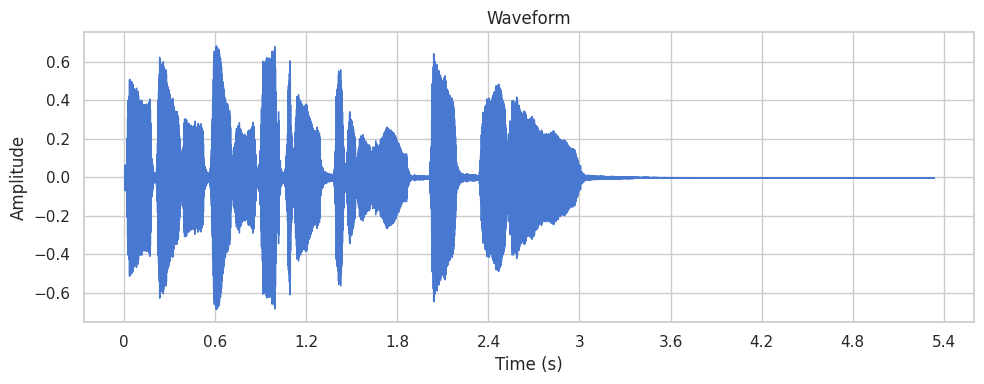

In [7]:
# Load an example audio file
y, sr = librosa.load(librosa.ex('trumpet'))

# Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [8]:
len(y)

117601

In [9]:
len(y)/39

3015.4102564102564

- The diagam above shows a plot of the signal i.e. a representation of the variation of air pressure around the microphone over time.

In [10]:
from pandas import Series

march = Series(y)
march[20000:20500]

,0
20000,0.199928
20001,0.260314
20002,0.254959
20003,0.142208
20004,-0.052800
...,...
20495,0.041029
20496,0.067597
20497,0.081770
20498,0.080362


<Axes: >

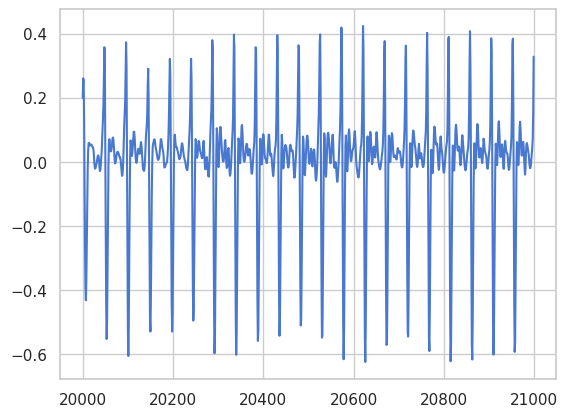

In [11]:
# Zoom in on a few hundredths of a second
march[20000:21000].plot()

### Audio Files

#### Audio data import

In [12]:
# Import the Speech Commands dataset
# https://arxiv.org/abs/1804.03209

data_dir = pathlib.Path('data/mini_speech_commands_extracted')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

# check the data
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Commands: ['mini_speech_commands' '__MACOSX']


In [13]:
# Extract the audio files into a list and shuffle it
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))

Number of examples: 11
Number of examples per label: 9


In [14]:
'''Reading audio files and their labels'''

def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)


def get_label(file_path):
    # Splits the file path into parts and gets the second last part (folder name)
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

In [15]:
# Take in the filename of the WAV file and output a tuple containing the audio and labels
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

test = filenames[1:6400]

# Build our data set to extract the audio-label pairs
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(test)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


## Speech Recognition

### Audio recognition

In [16]:
''' Simple audio recognition '''

# take a small sample of the files
test_files = filenames[:100]

# Reading audio files and their labels
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

# The label for each WAV file
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

# To take in the filename of the WAV file and output a tuple containing the audio and labels
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

# Build our data set to extract the audio-label pairs
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(test_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


### Check an audio waveforms with its corresponding labels

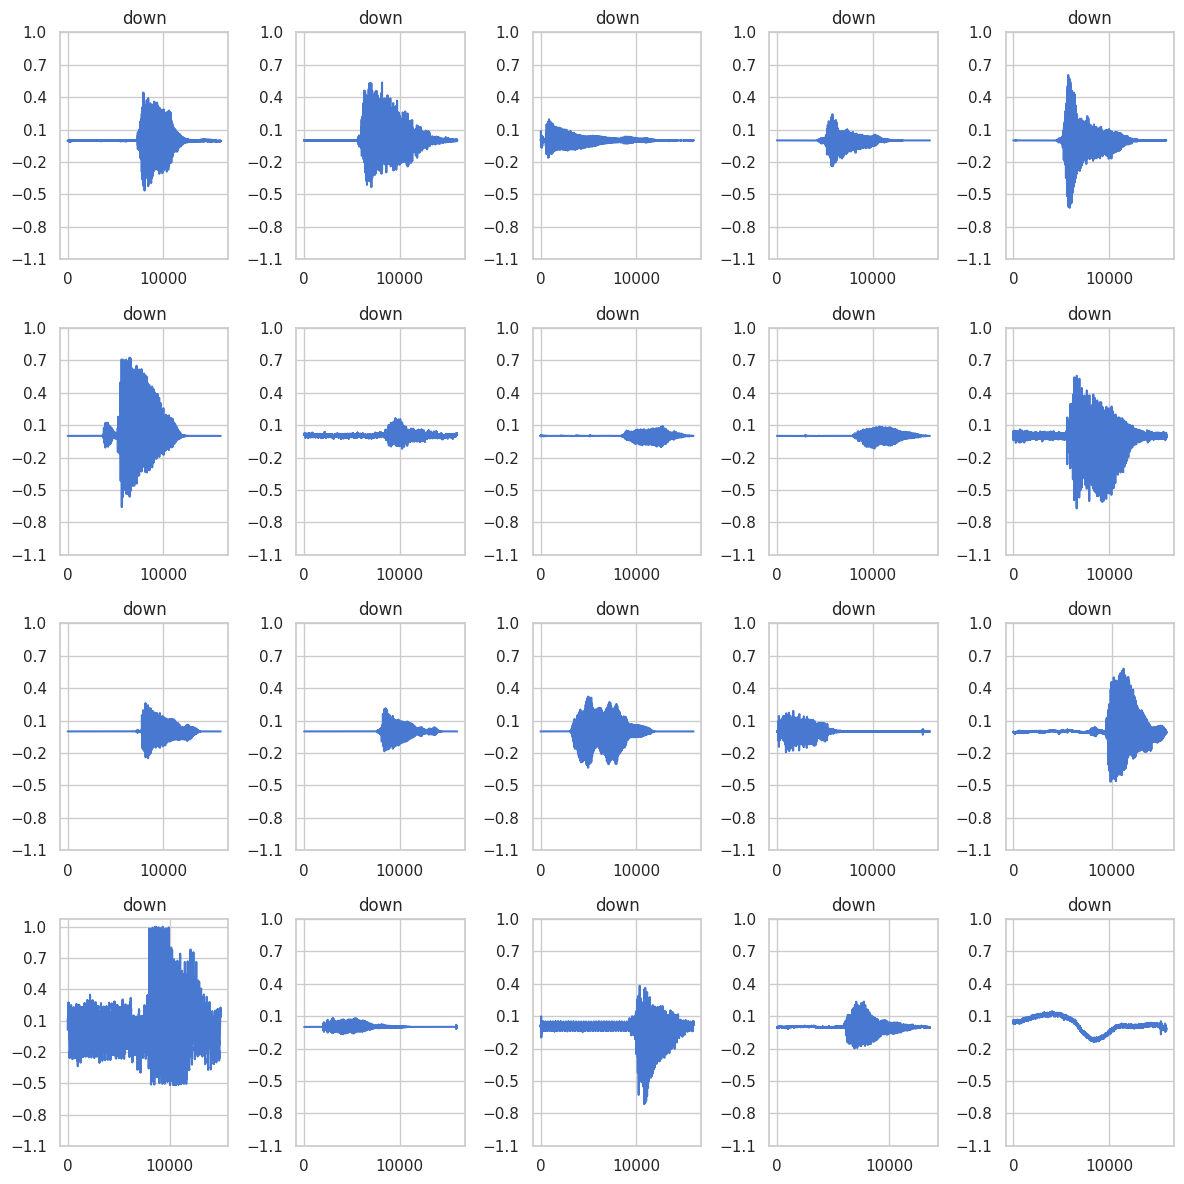

In [17]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# Get only the valid .wav files (exclude __MACOSX folders)
file_ds = tf.data.Dataset.list_files(
    "data/mini_speech_commands_extracted/mini_speech_commands/*/*.wav",
    shuffle=False
)

# Extract label from the folder name
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]  # e.g., "up", "down", etc.

# Decode the audio file
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

# Combine into one dataset mapping function
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

# Map the files to waveforms and labels
waveform_ds = file_ds.map(get_waveform_and_label)

# Plot some waveforms
rows, cols = 4, 5
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

for i, (audio, label) in enumerate(waveform_ds.take(rows * cols)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.1, 1.2, 0.3))
    ax.set_title(label.numpy().decode('utf-8'))

plt.tight_layout()
plt.show()


### Convert the waveform into a spectrogram

In [18]:
''' Convert the waveform into a spectrogram  '''
# Let's  shows frequency changes over time and can be represented as a 2D image

def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram


In [19]:
# Compare the waveform, the spectrogram and the actual audio of one example from the dataset
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


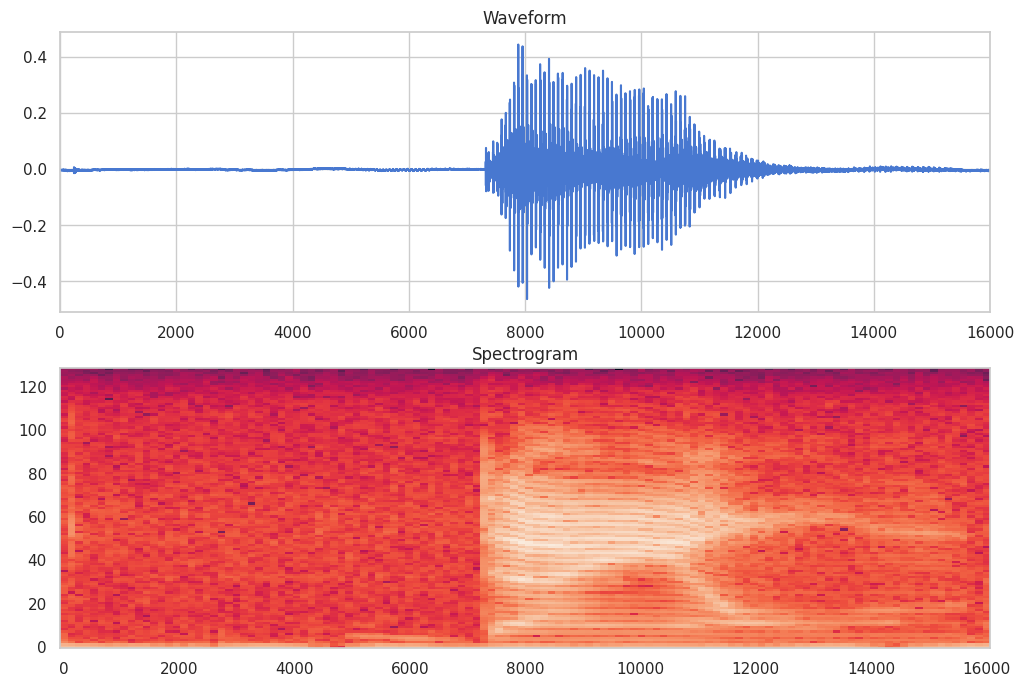

In [20]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

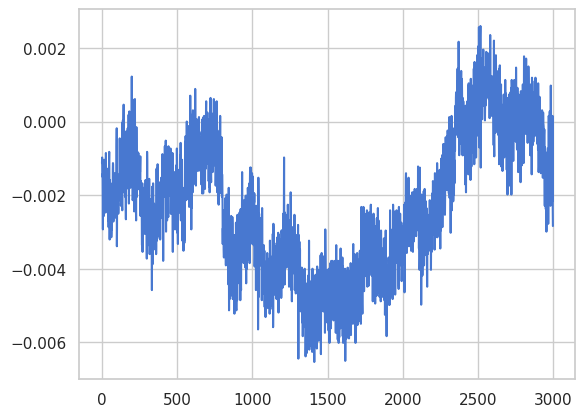

In [21]:
import matplotlib.pyplot as plt
# Plot a section of the waveform.
plt.plot(waveform.numpy().flatten()[2000:5000])
plt.show()

### Transform the waveform dataset

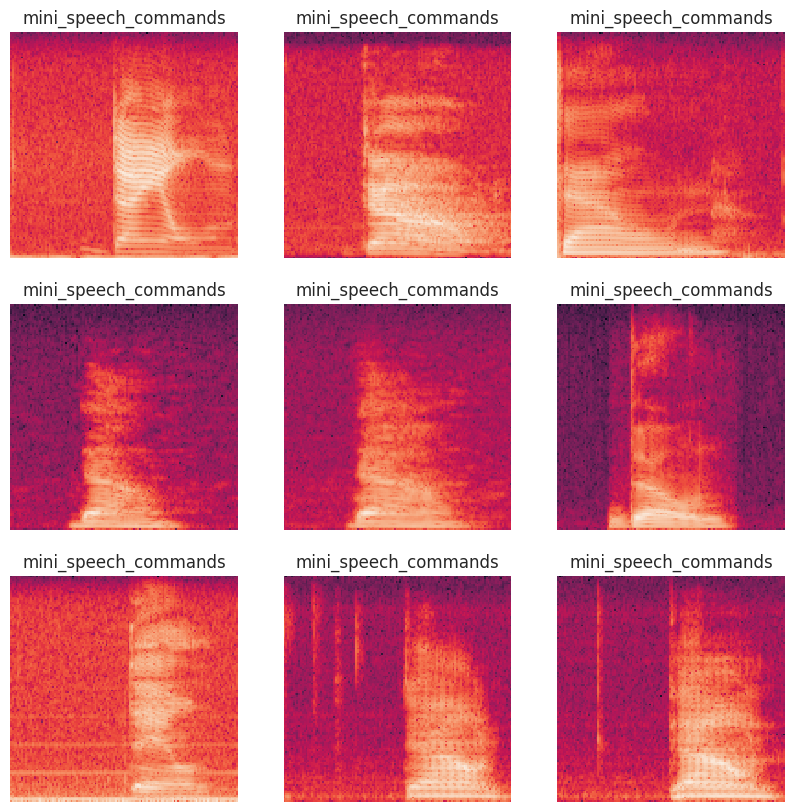

In [22]:
# transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

# Examine the spectrogram "images" for different samples of the dataset
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Speech Synthesis

### WaveNet

<center><img src="https://drive.google.com/uc?id=1GmcPbVDdYWrFZUVw7yZ3H7inOAXj7qD8" ></center>

The above diagram shows the relative quality scores assigned by human listeners to the best concatenative and parametric sytems vs. WaveNet and actual recordings.  WaveNet is a significant improvement over previous techniques.

<img src="https://lh3.googleusercontent.com/Zy5xK_i2F8sNH5tFtRa0SjbLp_CU7QwzS2iB5nf2ijIf_OYm-Q5D0SgoW9SmfbDF97tNEF7CmxaL-o6oLC8sGIrJ5HxWNk79dL1r7Rc=w1440-rw-v1">

[Source:[Talking Machines](https://deepmind.com/blog/article/wavenet-generative-model-raw-audio)]

#### WaveNet

In [24]:
# generated sample data using the generate_time_series()
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

# create a training set, a validation set, and a test set
n_steps=50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [29]:
import tensorflow as tf
from tensorflow import keras

# Custom metric: Mean Squared Error at the last time step
def last_time_step_mse(Y_true, Y_pred):
    last_true = Y_true[:, -1]
    last_pred = Y_pred[:, -1]
    return tf.reduce_mean(tf.math.squared_difference(last_true, last_pred), axis=-1)

# Optimizer setup
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# Build a simplified WaveNet-style Sequential model
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

# Add dilated causal Conv1D layers
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))

# Final Conv1D layer
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

# Compile model
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

# Fit model
history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid))


Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - last_time_step_mse: 0.0533 - loss: 0.0632 - val_last_time_step_mse: 0.0161 - val_loss: 0.0284
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - last_time_step_mse: 0.0153 - loss: 0.0270 - val_last_time_step_mse: 0.0126 - val_loss: 0.0246
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - last_time_step_mse: 0.0125 - loss: 0.0241 - val_last_time_step_mse: 0.0106 - val_loss: 0.0222
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - last_time_step_mse: 0.0108 - loss: 0.0225 - val_last_time_step_mse: 0.0108 - val_loss: 0.0220
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0094 - loss: 0.0210 - val_last_time_step_mse: 0.0077 - val_loss: 0.0194
